<a href="https://colab.research.google.com/github/Ivyson/Neural-Network-XOR/blob/main/Preprocess_BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Computer Interface Project

This serves as a step-by-step explanation to clarify the preprocessing that should be taken for this project and provide a background check as to why each preprocessing step is important. This is mainly useful to myself to track my progress and know which steps went wrong and to reason as to why. Also, this is for understanding concepts used in here.

## Step 1: Raw file loading

The list of the libraries needed for this project will be compiled at the end once we are sure of everything.

The core library used for this preprocessing is `mne` as it has most of the stuff done for us already, we just have to use them. We will use this library to open and manipulate the edf files. Download files using this link [Physionet](Link.will.be.attached.later.on). For simplicity, a single file will be loaded to the memory for processing to avoid memory overloads (when loading all the files at once).

## Step 2

Visualize the raw data straight up, visually checking channels which are having distorted, overshooting or just flat line signals. This will be useful for later steps whereby we choose bad channels and either discard them totally or remove the noise from the channel using Independent Component Analysis (ICA).

## Step 3

Now that we have spotted bad channels and their signals, we need to locate each channel, where it was placed on the scalp in order to understand its interference with the artifacts such as eye blinks (muscle movements) or power line noise. This is normally referred to as a montage. The montages are standard across the brain-computer interface, so we need to understand, from the experiment where the data was taken, how were the channels placed. For the case of Physionet’s dataset that we are using, they used a `standard_1010` system which is not available within the mne library, so we will later settle for `standard_1005` instead. But before all this, we need to fix the naming convention to fit the convention used by the built-in montages within mne. For this, we need to strip out white spaces and extra dotting included in Physionet’s dataset. Also, the naming of the channels is missing capitalization in some channels, so we need to fix that too. Once this is addressed, we can attach a montage of `standard_1005` to the dataset we are using.

## Step 4

For learning experience, we need to visualize the procedures we take. It's very important to see what each transform does to the dataset to understand its importance. So in this step, we are going to visualize the montage we just attached to the data and check where each channel is located. The channels lying outside of the head plot are just slightly above your eyes (Anterior Frontal, Frontal Pole, Frontal Pole Middle → AF, Fp, Fpz). Due to the structure of the plot, they cannot be plotted on the head straight up, hence lying outside.

## Step 5

Now that we have figured the placement, we need to start with the intricate preprocessing steps, firstly being band-pass filtering. This comes from understanding the tasks we want to isolate. For example, we need to isolate signals associated with motor tasks. These signals are within the frequencies (1, 30), anything above that could potentially be adding noise to our data, so it should be filtered out. So we create a band-pass filter to just place focus on this range alone and negate the rest of the spectrum.

In many applications, they also add notching, but for the case of this experiment, that will not be included. This comes from the idea that power line frequency is between 50 Hz and 60 Hz, and anything above 40 for our case has already been filtered out, so no necessity for notching.

## Step 6

Now, our signal is supposed to look less dense ever since we discarded some of the signals within the dataset, right? Well, we need to see that, so that is why this step includes visualizing the power spectrum density. This plots the power that each frequency spectrum has. In this plot, we need to see the frequencies above 40 being flat as they are clipped out. To make this easier to visualize, we need to make use of `raw.copy` to copy the contents of the actual data. This is important because mne creates modifications to the file real-time as we edit it. So let `raw` have the actual unprocessed data and `raw_copy` have the filtered data, plot the power spectrum density for both datasets and inspect the difference to see if the filtering changed anything.

## Step 7

Now, this step gets slightly deeper. We now need to understand a little bit about the brain structure in order to determine what channels would be best for this experiment. Remember, the goal is to have a lightweight system that performs as good as one can possibly make it. To get to the lightweight infrastructure, we need to feed in only useful data to the model, and anything that can make the model deeper than it should, should be discarded. We will dissect a bit about the brain. The human brain on the high level is divided into 3 sub-sections:

* **Cerebrum**: This is the largest part of the brain, it is the outermost part of the brain just below the top of the skull. It’s responsible for higher order functions like thinking, **voluntary movement**, language and perception.
* **Cerebellum**: This is located below the cerebrum and is located at the back of the head. It's mostly important for coordination, **motor control**, and balance.
* **Brain stem**: This connects the Cerebrum and Cerebellum to the spinal cord. It controls vital functions like breathing and heart rate, etc.

Now, the **cerebrum** is divided into 4 parts too:

1. Frontal Lobe:

   * Location: At the front of the brain, behind the forehead
   * Function: Language production, Motor Cortex, personality, etc.
2. Parietal Lobe:

   * Location: Behind the Central sulcus, at the top (Fp) and back (PO) of the brain
   * Function: Processing sensory information (pain, temperature, etc.)
3. Temporal Lobe:

   * Location: At the sides of the head (near the ears)
   * Function: Auditory processing, memory formation, language understanding, facial recognition & emotion processing.
4. Occipital Lobe:

   * Location: Far back of the head
   * Function: Visual processing (Visual cortex)

While Central has been mentioned multiple times with the lobes, it isn't necessarily a lobe, but a reference point that imitates an equator which separates regions of the brain.

Now, the major component of this step is to pick necessary channels which are responsible for motor tasks. \[C3, Cz, C4, FC1, CP1, CP2, C2, C5, P3, P4, O2]

## Step 8

Now, we have fewer channels, filtered signals and the position of the channels respectively. The only thing left is artifact removal. The easier way of understanding this concept is through the multiple microphones problem. Just like audio signals, EEG channels can record data from other channels (microphone recording voices of people closer to the actual speaker). We now need to find the different voices in the recorded signal and then determine whose voice this is and eliminate the voices that shouldn't be transmitted anyway. In our instance, we make use of Independent Component Analysis to determine each independent source electrode. Because we have been able to set the positions of the electrodes before (the montages), the ICA will be able to track where each signal comes from. This will be shown using `ica.plot_components()`, which will show head plots with corresponding signal source. Then we can remove signals from eye blinks using EOG removal and from heartbeats too.

## Step 9

Apply the changes obtained from ICA to the data and inspect if the eye blink spikes and consistent heartbeats are removed from the signals. If not, try manually removing bad channels here and bad components. Then inspect it a couple of times to ensure that the signal is as it is supposed to look.

## Step 10

Now, we have fewer channels and filtered frequencies, let’s inspect the power spectrum density of the manipulated data. Check if the power is stable and there are no misbehaving components.

## Step 11

Great progress so far. Now we can further use covariance matrix and other advanced pyRiemann's manipulation, but for now, we can stop here with preprocessing. The next step has to do with epoching data, which is just a programming slang used to say: divide the continuous data into equal windows that we will later feed into the Machine Learning Algorithm. If you have been paying enough attention you will notice that for all the `raw.plot(...)`, the Y-axis has been showing the channel names, the X showing the time window, and at the top of the graph there are labels indicating when an event occurs and when does it stop (for labelled data). Also, mne makes use of different colors to distinguish between different events. So, we need to extract those events from annotations (annotations are the labels on a data, e.g., T0, T1 etc.). The events in the data being used last for around 4.1 seconds, so we can divide the data in windows of 4.0 or 4.1 seconds per time. The baseline option seems very important, I do not entirely understand its functionality yet, but for this case, ever since we are not starting at a preparatory event (a case


whereby a person prepares for a motor task, then signal in the brain should have a consistent pattern to show that this person is about to execute this specific task), when we baseline, we start at the preparatory and then every event is being considered with reference to the point of preparation. The baseline is set to none for our case then.

## Step 12

Now, we need to follow our rule of thumb to always plot aspects to see what we are currently working on and how it is behaving. So, we will visualize how these events take place.

## Step 13

Remove bad epochs, all the data that was not windowed should be deleted as it is contaminated.

## Step 14

Now, we are approaching the last sections of our preprocessing. Last step executed is **Welching**, which takes in the split data (epoched data) represented in the time domain. This data is windowed in such a way that it overlaps by a certain percentage that you can experiment with, but usually 50% has been working effectively.

Now, the problem with windowed data is that it starts sharply and ends suddenly. This could create artifacting. To fix this, a windower is applied (Hanning window) to smooth out the fade-in and fade-out of the data. This reduces sudden jumps at the edges which would confuse Fourier Transforming of this signal.

After windowing, the signal is transformed into a frequency spectrum using Fast Fourier Transform. This will compute all the frequencies available within the provided signal. The same frequencies will be fed into a band power, whereby we will determine the amount of power each frequency element has.
$\text{Power} = |\text{FFT OUTPUT}|^2$

Then the resulting power is averaged to create a smoother power estimate. This process is done for each channel.

The resulting values are the ones we are going to feed into our models.

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.3 MB/s eta 0:00:00


In [ ]:
import mne

raw = mne.io.read_raw_edf('/content/S006R04.edf', preload=True)
raw.info

Extracting EDF parameters from /content/S006R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

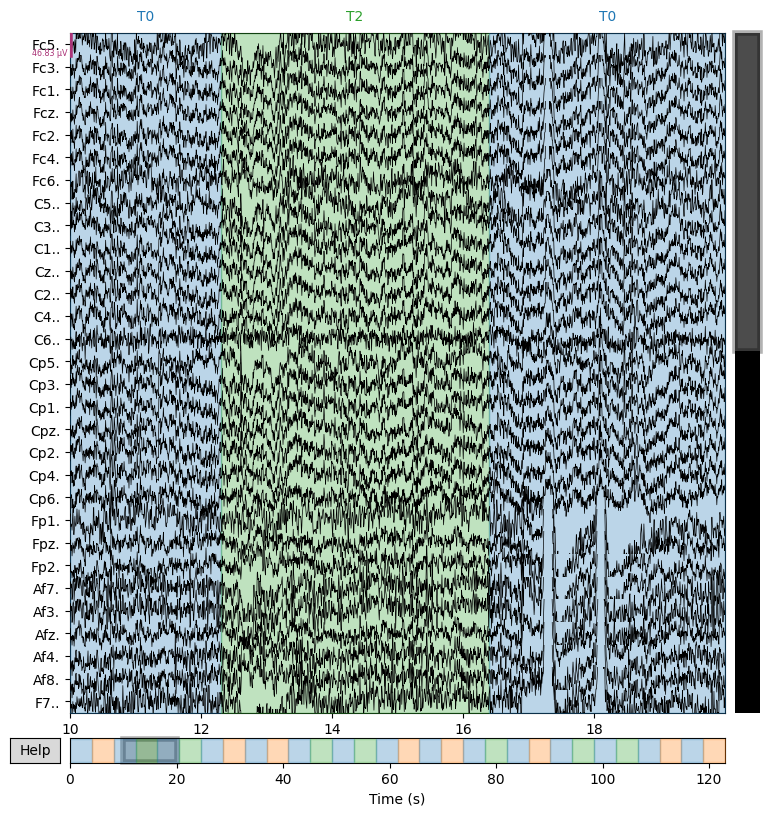

In [ ]:
raw.plot(
    n_channels = 30,
    scalings = 'auto',
    title = 'Raw EEG Data',
    duration = 10.0,
    start = 10.0
);

In [ ]:
channels = raw.ch_names
channels = [x.replace('.', '').strip() for x in channels ] # Remove extra dots and trailing white space
print(channels)

['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz']


In [ ]:
raw.rename_channels(dict(zip(raw.ch_names, channels)))

<RawEDF | S006R04.edf, 64 x 19680 (123.0 s), ~9.7 MiB, data loaded>

In [ ]:
montage = mne.channels.make_standard_montage('standard_1005')
def channel_renamer(raw, montage):
  montage_names = {name.lower(): name for name in montage.ch_names}
  # print(f'Montages: {montage_names}')
  raw_names = {}
  for channel in raw.ch_names:
    cleaner = channel.strip('.').lower()
    if cleaner in montage_names:
      # print(cleaner)
      # print(montage_names)
      raw_names[channel] = montage_names[cleaner]
      # print(f'Name updated from {cleaner} to {raw_names[channel]}')
  raw.rename_channels(raw_names)
  return raw


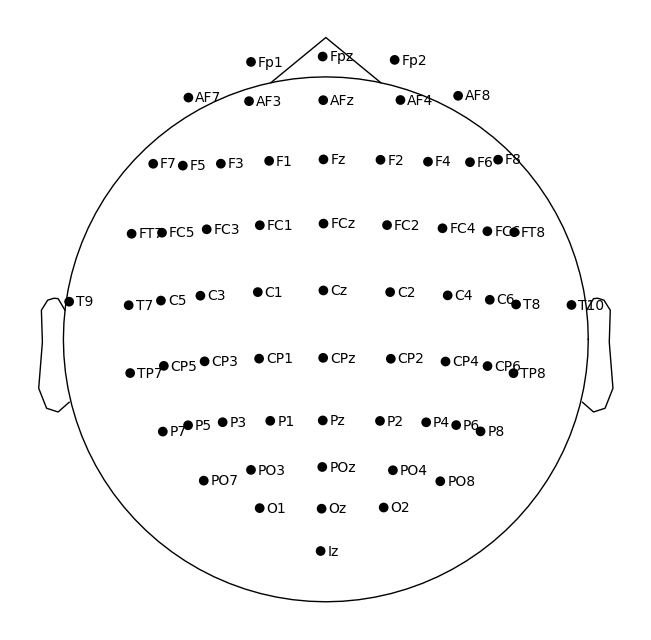

In [ ]:
raw_copy = channel_renamer(raw.copy(), montage)
raw_copy.set_montage(montage)
raw_copy.plot_sensors(show_names=True);

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 5281 samples (33.006 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-114-4159746859.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)


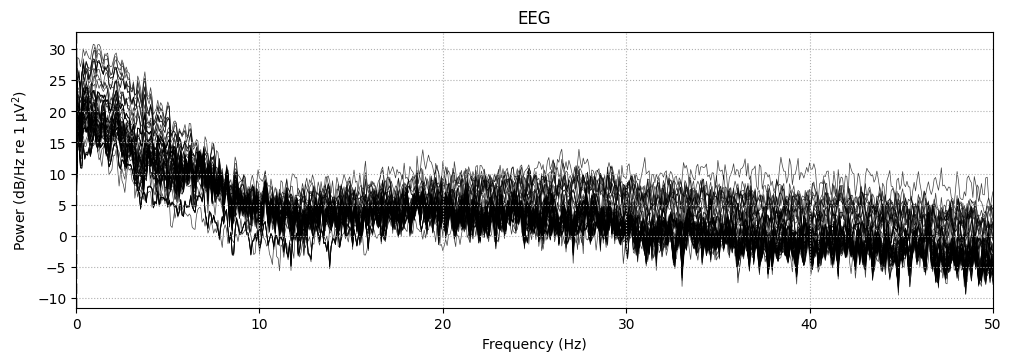

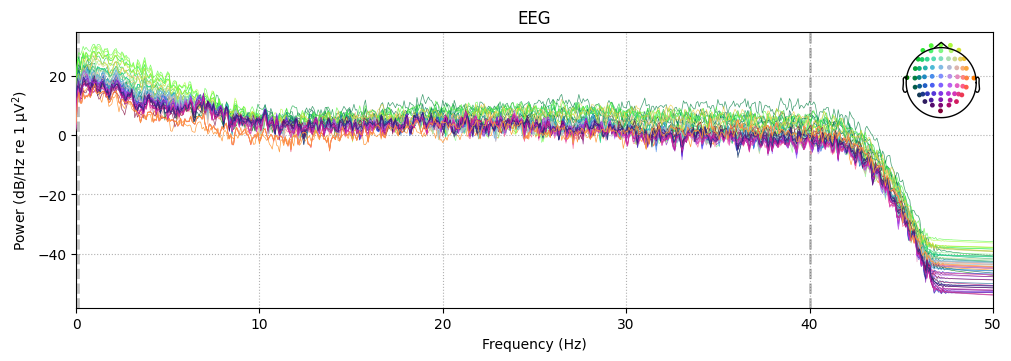

In [ ]:
# Now, filtering the unnecesary frequencies
raw_copy.filter(l_freq=0.1, h_freq=40)
raw.plot_psd(fmax=50)
raw_copy.plot_psd(fmax=50);

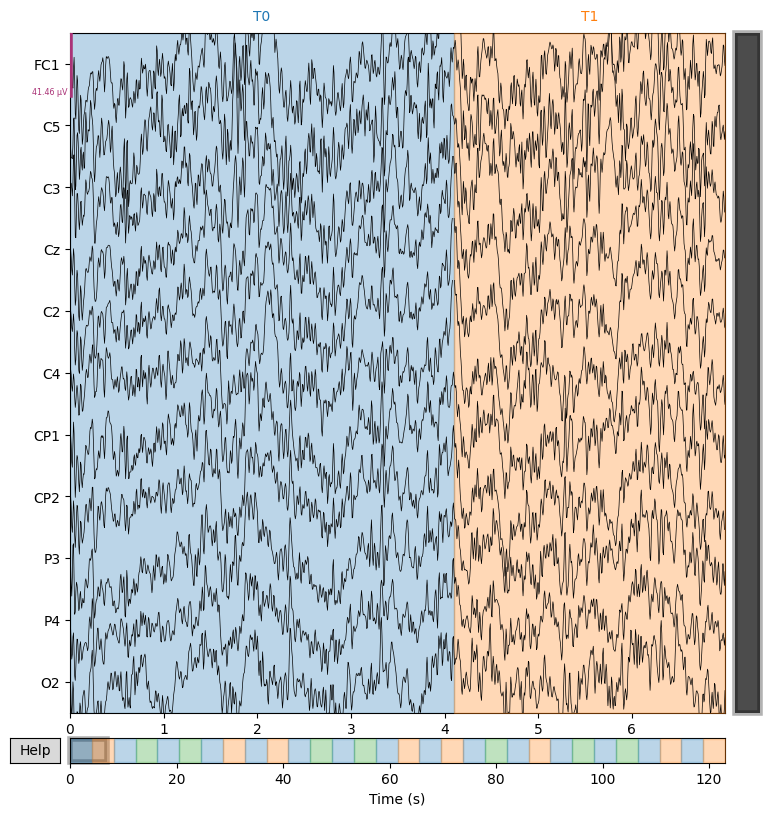

In [ ]:
# Use Motor Task related channels and drop everything else
motor_channels = ['C3', 'Cz', 'C4', 'FC1', 'CP1', 'CP2', 'C2', 'C5', 'P3', 'P4',  'O2']

raw_copy.plot(
    picks= motor_channels,
    scalings = 'auto',
    title = 'Raw EEG Data',
    duration = 7.0
);

In [ ]:
raw_pick = raw_copy.copy().pick_channels(motor_channels)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [ ]:
raw_pick.set_eeg_reference('average', projection=False)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | S006R04.edf, 11 x 19680 (123.0 s), ~1.7 MiB, data loaded>

In [ ]:
!pip install picard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 30.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 17.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for picard (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for picard
  Created wheel for discid: filename=discid

In [ ]:
from mne.preprocessing import ICA

ica_raw = raw_pick.copy()
ica = ICA(n_components=8, random_state=97, max_iter=800, method='fastica')
ica.fit(ica_raw)

Fitting ICA to data using 11 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 18.6s.


<ICA | raw data decomposition, method: fastica (fit in 428 iterations on 19680 samples), 8 ICA components (11 PCA components available), channel types: eeg, no sources marked for exclusion>

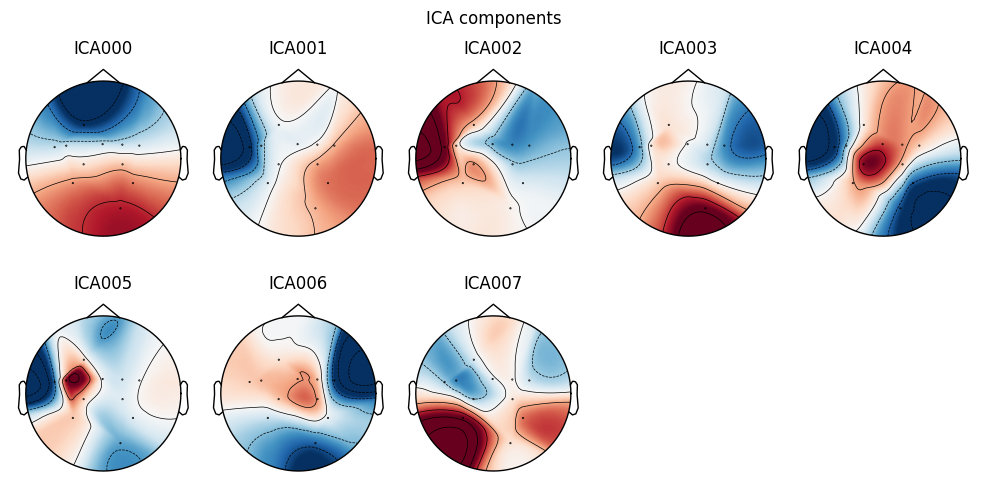

In [ ]:
ica.plot_components(inst = ica_raw);

In [ ]:
# # Auto-detect EOG - Eyes
# eog_inds, scores = ica.find_bads_eog(raw_pick, ch_name='FC1')
# ica.exclude = eog_inds

# # Auto detect Heartbeat
# hb_inds, scores = ica.find_bads_ecg(raw_pick, ch_name='Cz')
# ica.exclude = hb_inds
ica.apply(ica_raw)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 11 PCA components


<RawEDF | S006R04.edf, 11 x 19680 (123.0 s), ~1.7 MiB, data loaded>

Creating RawArray with float64 data, n_channels=8, n_times=19680
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.


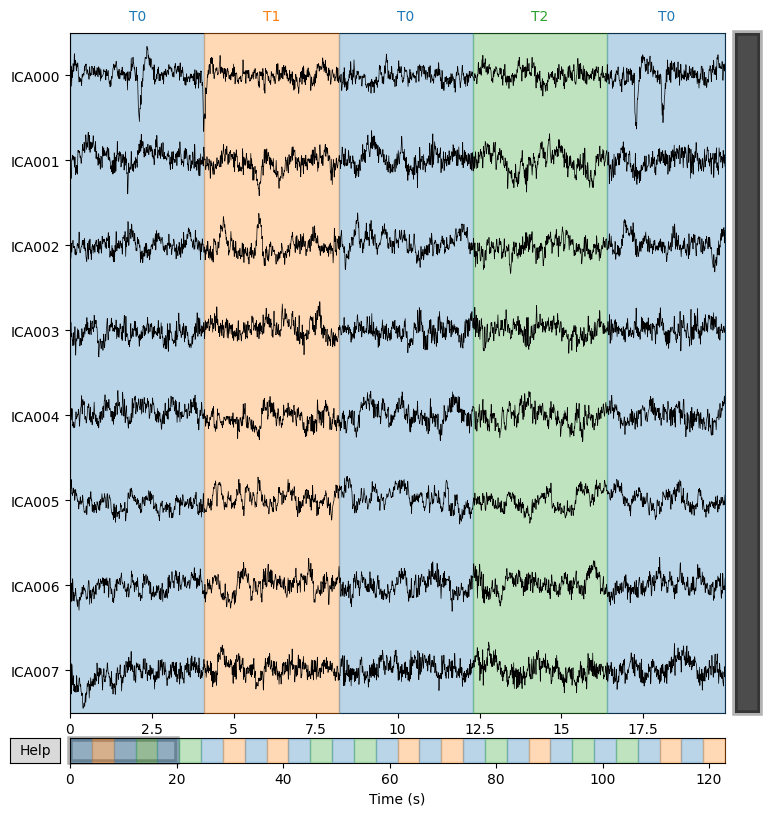

In [ ]:
ica.plot_sources(ica_raw);

In [ ]:
ica_raw.interpolate_bads(reset_bads=True)

Setting channel interpolation method to {'eeg': 'spline'}.


/tmp/ipython-input-187-3851721849.py:1: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  ica_raw.interpolate_bads(reset_bads=True)


<RawEDF | S006R04.edf, 11 x 19680 (123.0 s), ~1.7 MiB, data loaded>

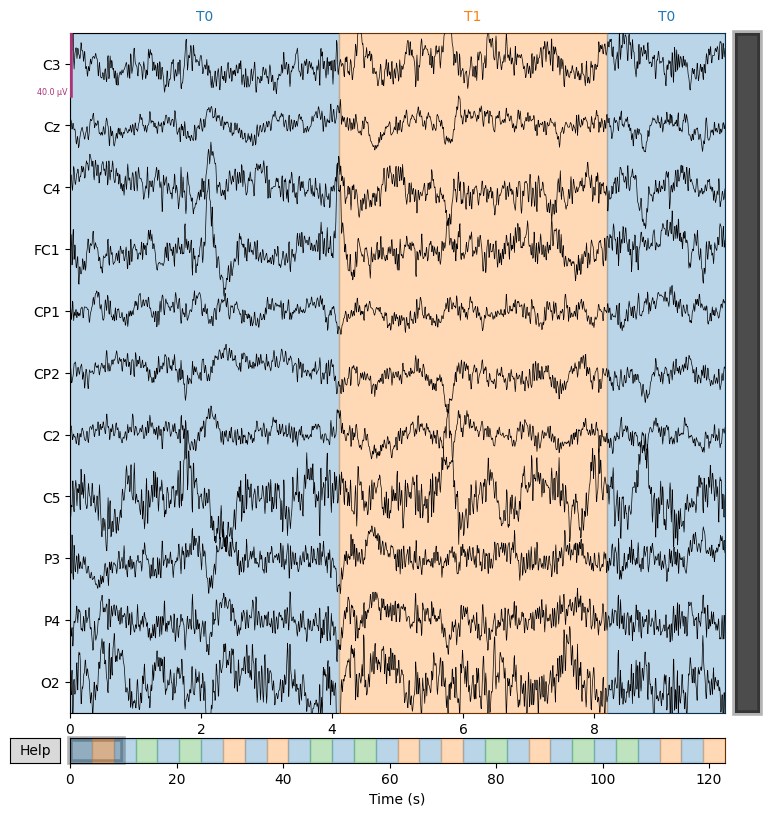

In [ ]:
ica_raw.plot();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


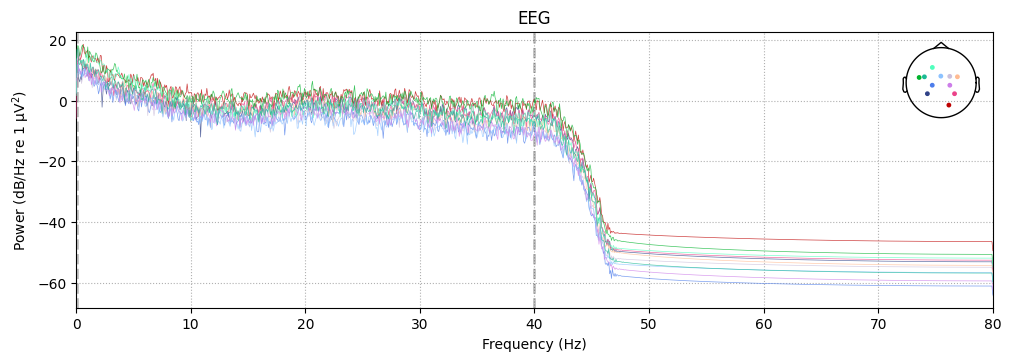

In [ ]:
ica_raw.plot_psd();

In [ ]:
events_id, event = mne.events_from_annotations(ica_raw)

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]


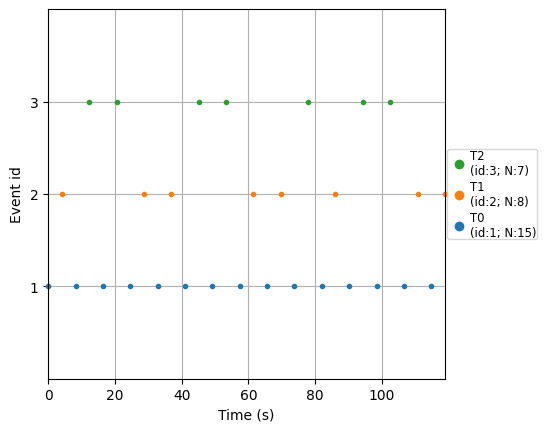

In [ ]:
mne.viz.plot_events(events=events_id, event_id=event, sfreq=ica_raw.info['sfreq'], first_samp=events_id[0][0]);

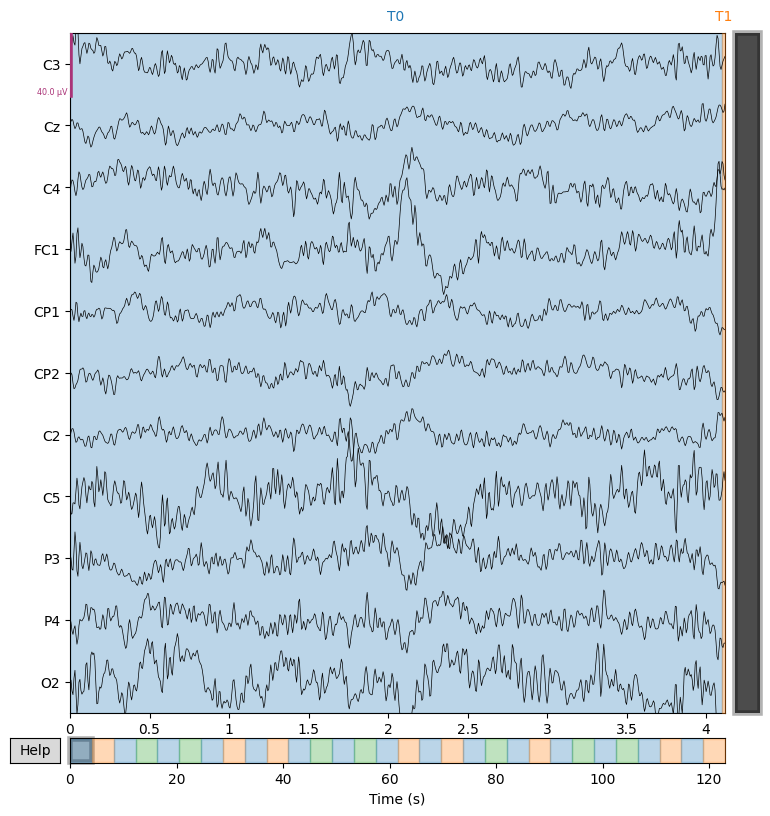

In [ ]:
# check when does an event occur
ica_raw.plot(duration = 4.12);

In [ ]:
tmin = 0.0
tmax = 4.1
epochs = mne.Epochs(
    ica_raw,
    events_id,
    event_id=event,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    preload=True
)
epochs.drop_bad(reject=dict(eeg=150e-6))

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 657 original time points ...
1 bad epochs dropped
0 bad epochs dropped


<Epochs | 29 events (all good), 0 – 4.1 s (baseline off), ~1.6 MiB, data loaded,
 np.str_('T0'): 15
 np.str_('T1'): 7
 np.str_('T2'): 7>

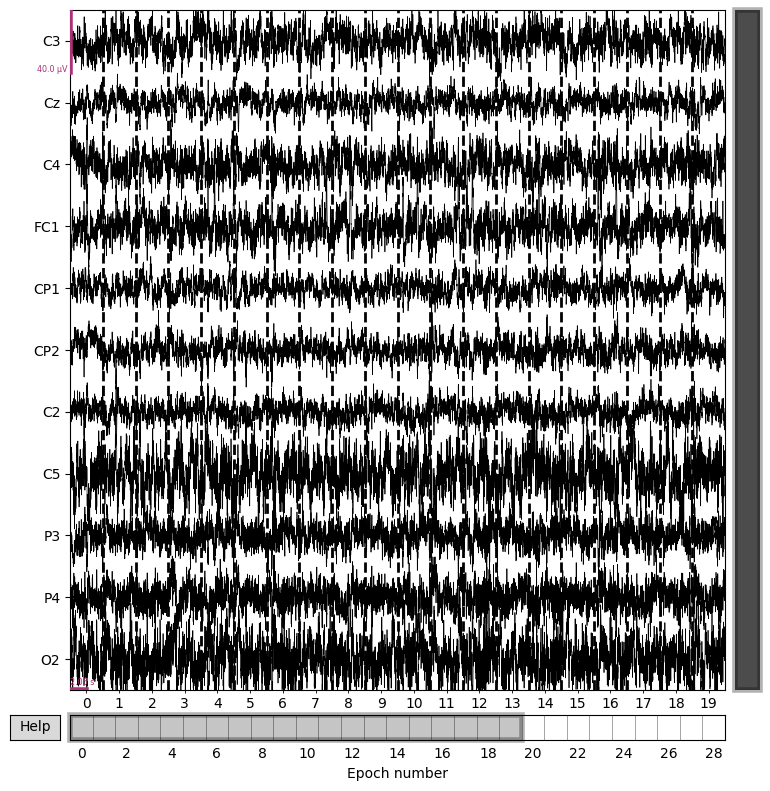

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


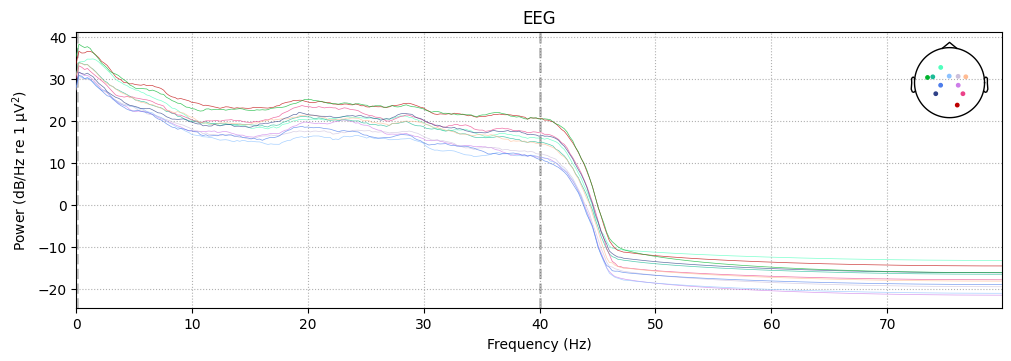

In [ ]:
epochs.plot();
epochs.plot_psd();

In [ ]:
epochs.apply_baseline((0.0, .2))

Applying baseline correction (mode: mean)


<Epochs | 29 events (all good), 0 – 4.1 s (baseline 0 – 0.2 s), ~1.6 MiB, data loaded,
 np.str_('T0'): 15
 np.str_('T1'): 7
 np.str_('T2'): 7>

In [ ]:
# Feature extraction
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from mne.time_frequency import psd_array_welch
from sklearn.model_selection import cross_val_score
import numpy as np

mu_band = (8, 12)
beta_band = (13, 30)

X = epochs.get_data()
sfreq = ica_raw.info['sfreq']

psds_list = []

for i in X:
    psds, freq = psd_array_welch(i, sfreq=sfreq, fmin=8, fmax=30, n_fft=256)
    psds_list.append(psds)

psds_array = np.array(psds_list)
logs_psds = np.log(psds_array)

Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)


In [ ]:
def bandpower(psds, freq, bands):
    idx = np.logical_and(freq >= bands[0], freq <= bands[1])

    return psds[:, :, idx].mean(axis=2)

mu_power = bandpower(logs_psds, freq, mu_band)
beta_power = bandpower(logs_psds, freq, beta_band)


# concatinate features
X = np.concatenate([mu_power, beta_power], axis=1)

In [ ]:
labels = epochs.events[:, 2]